In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

from pylib.draw_nn import draw_neural_net_fig

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_nn.py -->

# Deep Neural Networks

## What is deep learning?

Deep learning is a branch of machine learning that tries to emulate the biological structure and function of the brain using artificial neural networks. These networks include: 

- Multilayer Perceptron Networks
- Convolutional Neural Networks
- Recurrent Neural Networks

Additionally, these networks are hierarchical or multilayered, enabling them to model high-level abstractions in data. For this reason, deep learning is also called **hierarchical learning**. (Notice how there are two hidden layers in the figure of the multilayer perceptron network below.)

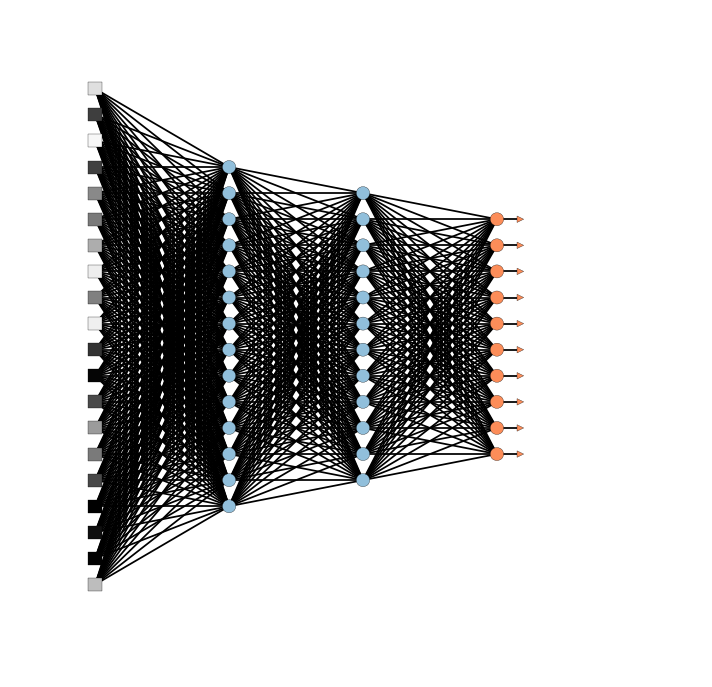

In [4]:
draw_neural_net_fig([20, 14, 12, 10])

There are benefits to using hierarchical models. In contrast to the performance of older machine learning algorithms, the performance of deep learning algorithms scales with the amount of data they are trained on -- the more data, the better the model. Consequently, deep learning algorithms typically outperform traditional ones. These models also have the ability to automatically extract features from data in a process called [feature learning](https://en.wikipedia.org/wiki/Feature_learning). This ability eliminates the need for a priori knowledge of the data to construct features, which is particularly useful when dealing with complex data such as images.  

Deep learning has some pretty neat applications. Not only can we classify images with a high degree of accuracy, but we can also use deep learning algorithms to [generate captions](https://research.googleblog.com/2016/09/show-and-tell-image-captioning-open.html), [summarize](https://research.googleblog.com/2016/08/text-summarization-with-tensorflow.html) and [translate](https://research.googleblog.com/2016/09/a-neural-network-for-machine.html) text, [generate audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), and [produce art](https://github.com/lengstrom/fast-style-transfer/). 


## Multilayer perceptron

We will start by replicating some of the code we used for our basic neural network. 

In [5]:
mnist = input_data.read_data_sets('/tmp/data', one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
N_PIXELS= 28 * 28
N_CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.5

hidden_size = 64

### Initializing Weights and Biases

As a reminder, we want to initialize our weights with random values to break symmetry between neurons in a hidden layer. Additionally, we want to choose small values to avoid the **gradient vanishing problem**, where the weighted sum of the inputs (plus a bias) fall on the flat portion of the sigmoid curve. What is the proper scale of the weights?  Most of our activation functions have their best response for inputs of $\mathcal O(1)$.  If we have $m$ random inputs, each of $\mathcal O(1)$, we expect their sum to scale as $\sqrt m$.  Therefore, weights are often chosen randomly with a mean of zero and standard deviation of $1/\sqrt m$.

For very large layers, this gives rather small weights.  An alternative approach is to only provide $k < m$ non-zero weights when initializing neurons.  This scheme, known as **sparse initialization**, provides more diversity amongst the neurons at initialization.  It can, however, also produce very slow convergence as "incorrect" choices of non-zero weights have the be removed.

In the code below, we initialize our weights by sampling from a truncated normal distribution, where any weights greater than 2 standard deviations from the mean is re-picked. We also initialize the biases to zero. 

In [7]:
def initializer(shape):
    return tf.truncated_normal(shape, stddev=shape[0]**-0.5)

### Adding Hidden Layers

A single layer neural network only works well on linearly separable data. By adding one more layer, we can solve most classification problems. The exercise at the end of the basic neural network notebook was to add a layer to our model to improve the accuracy of our predictions. We will present the solution below.

In [8]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, N_CLASSES], name="labels")
training = tf.placeholder(tf.bool, name="training")

This training placeholder will be used later to indicate whether we are in the process of training or prediction.  Right now, it is extraneous.

In [9]:
W1 = tf.Variable(initializer([N_PIXELS, hidden_size]), name="weights")
b1 = tf.Variable(tf.zeros([hidden_size]), name="biases")

hidden = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

W2 = tf.Variable(initializer([hidden_size, N_CLASSES]), name="weights2")
b2 = tf.Variable(tf.zeros([N_CLASSES]), name="biases2")

y = tf.matmul(hidden, W2) + b2

We'll put the training loop in a function so we can reuse it later.

In [10]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

def train_mnist(x, y_label, loss, accuracy, train, training, steps_total, steps_print):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    reset_vars()
    for i in xrange(steps_total):
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        sess.run(train,
                 feed_dict={x: batch_x, y_label: batch_y, training: True})
        if i % steps_print == 0 or i == steps_total - 1:
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.test.images,
                                       y_label: mnist.test.labels,
                                       training: False})
            metrics['test_loss'].append(l)
            metrics['test_acc'].append(a)
            print "Test:  %0.5f, %0.5f" % (l, a)
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.train.images, 
                                       y_label: mnist.train.labels,
                                       training: False})
            metrics['train_loss'].append(l)
            metrics['train_acc'].append(a)
            print "Train: %0.5f, %0.5f" % (l, a)
    return metrics

train_mnist(x, y_label, loss, accuracy, train, training, 10000, 1000);

Test:  2.30509, 0.09550
Train: 2.30413, 0.09835
Test:  0.23744, 0.93030
Train: 0.24451, 0.92940
Test:  0.18522, 0.94640
Train: 0.18421, 0.94716
Test:  0.14884, 0.95700
Train: 0.14094, 0.96055
Test:  0.13032, 0.96270
Train: 0.11992, 0.96591
Test:  0.11591, 0.96630
Train: 0.10463, 0.97025
Test:  0.10849, 0.96820
Train: 0.08904, 0.97605
Test:  0.10309, 0.96940
Train: 0.08126, 0.97789
Test:  0.09554, 0.97170
Train: 0.07259, 0.98051
Test:  0.09069, 0.97250
Train: 0.06430, 0.98300
Test:  0.08738, 0.97340
Train: 0.05879, 0.98425


## Layer API

Setting up all of this math is obviously going to get tedious as we increase the number of layers. To address this, TensorFlow provides a [layers API](https://www.tensorflow.org/api_docs/python/tf/layers), which lets us create individual layers with a single line.  Let's recreate this two-layer network in the new API.

The input tensors are created in the same way as before.

In [11]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")

We have been using **dense** layers.  That is, each neuron is connected to all of the inputs to the layer.  First we create thie hidden layer:

In [12]:
hidden = tf.layers.dense(x, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5))

This sets up a weight matrix (referred to as the **kernel**, for reasons to be discussed later) of `size(x)`$\times$`hidden_size`, multiplies it with $x$, adds a bias term (since `use_bias=True`), and sends the result through the sigmoid activation function.  We use the same truncated normal initializer for the weights as before.

We use a second dense layer to produce the final output.  We don't need an activation function here, as we'll feed it into the softmax function ourselves.

In [13]:
y = tf.layers.dense(hidden, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

The training proceeds identically to before.

In [14]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

train_mnist(x, y_label, loss, accuracy, train, training, 10000, 1000);

Test:  2.32810, 0.15380
Train: 2.33290, 0.14778
Test:  0.23485, 0.93150
Train: 0.24335, 0.92962
Test:  0.18019, 0.94780
Train: 0.17957, 0.94802
Test:  0.14920, 0.95690
Train: 0.14525, 0.95893
Test:  0.13053, 0.96120
Train: 0.12186, 0.96558
Test:  0.11842, 0.96430
Train: 0.10539, 0.97064
Test:  0.10843, 0.96670
Train: 0.09164, 0.97476
Test:  0.10115, 0.96920
Train: 0.08115, 0.97820
Test:  0.09903, 0.97040
Train: 0.07413, 0.97933
Test:  0.09260, 0.97440
Train: 0.06719, 0.98164
Test:  0.09194, 0.97150
Train: 0.06058, 0.98378


This API makes it easy to add layers and neurons to neural network. However, in doing so, we run the risk of overfitting our model. 

## Overfitting

*N.B. Increase `n_steps` and then run the rest of the notebook, since some of the cells take a while to run.*

In [15]:
n_steps = 50000 # 50000

The more complex a model, the greater the danger of **overfitting**.  Overfitting occurs when the model becomes so powerful that it can fit not only the general signal but also the specific noise present in your training data.

Let's start with a simple contrived example.  We'll make up a set of data (blue dots) and fit it with two curves, a linear model (green) and a $19^{th}$-degree polynomial model (red).  The results are below:

Linear Model MSE (train): 0.00245013056305
Polynomial Model MSE (train): 0.000102825831819


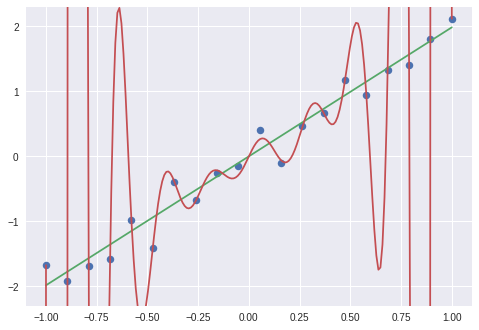

In [16]:
x = np.linspace(-1, 1, 20).reshape(-1, 1)
xl = np.linspace(-1, 1, 200).reshape(-1, 1)
X = np.column_stack(x**n for n in xrange(1,20))
XL = np.column_stack(xl**n for n in xrange(1,20))

np.random.seed(1)
y = 2 * x + np.random.normal(0, .2, (20, 1))

m, _, _, _ = np.linalg.lstsq(x, y)
W, _, _, _ = np.linalg.lstsq(X, y)

plt.plot(x, y, '.', ms=15)
plt.plot(xl, xl.dot(m))
plt.plot(xl, XL.dot(W))
plt.ylim(-2.3, 2.3)

print "Linear Model MSE (train):", np.mean((y - x.dot(m))**2) / len(y)
print "Polynomial Model MSE (train):", np.mean((y - X.dot(W))**2) / len(y)

Which model is the better model?  If you simply look at the mean-squared error, it's the polynomial model.  It's error is less than a tenth of that of the linear model, and we see that it goes almost right through all the data points.

But most of us would look at this result and agree that the linear model is more likely.  There's nothing to suggest that those large excurions at either extreme is actually real.  Our intuition tells us that it's more likely we have a simple underlying signal with some noise than a complicated underlying signal.

Ultimately, the only way to tell for sure is to test with additional data.  Therefore, it's standard practice to separate our data into training and test, or validation, sets.  These sets should share the same target signal, but they will have different noise.

Since we're just making up data for the example, we'll make up a test data set here as well.

Linear Model MSE (test): 0.0025818135082
Polynomial Model MSE (test): 16843.838023


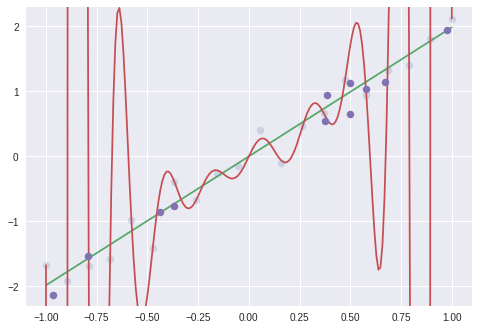

In [17]:
xt = np.random.uniform(-1, 1, 11).reshape(-1, 1)
XT = np.column_stack(xt**n for n in xrange(1,20))

yt = 2 * xt + np.random.normal(0, .2, (11, 1))

plt.plot(x, y, '.', ms=15, alpha=0.2)
plt.plot(xl, xl.dot(m))
plt.plot(xl, XL.dot(W))
plt.plot(xt, yt, '.', ms=15)
plt.ylim(-2.3, 2.3)

print "Linear Model MSE (test):", np.mean((yt - xt.dot(m))**2) / len(yt)
print "Polynomial Model MSE (test):", np.mean((yt - XT.dot(W))**2) / len(yt)

In this case, we see that the linear model behave comparably on the training and test sets, which tells us it is not overfitting.  The polynomial model, on the other hand, does terribly worse on the test set, telling us that it is very much overfit.

This should not surprise us.  The polynomial model had 19 degrees of freedom and only 20 points to go through.  Of course it could get near to all of them!

Now consider that neural net.  The hidden layer alone as `N_PIXELS` $\times$ 64 weights acting as degrees of freedom.  Including the weights in the output layer and the biases, there are 50,890 degrees of freedom in this model.  Our training set has only 55,000 observations in it, so it might seem that overfitting should be a huge problem.  While there is some evidence of overfitting in the split between the training and test sets, it isn't so large.

In fact, neural networks have a surprising ability to resist overfiting, given their flexibility.  This resistance is not absolute, though; given enough freedom, a neural net will eventually overfit.  There are countermeasures.  To demonstrate them, we'll first build a larger network that will overfit more easily.  This will have two hidden layers of 256 neurons each.

In [18]:
hidden_size = 256

In [19]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")

hidden1 = tf.layers.dense(x, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5))

hidden2 = tf.layers.dense(hidden1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

y = tf.layers.dense(hidden2, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

Training will take a bit longer now.

In [20]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

res = train_mnist(x, y_label, loss, accuracy, train, training, n_steps, 1000);

Test:  3.15197, 0.10280
Train: 3.14550, 0.10391
Test:  0.32844, 0.89950
Train: 0.33667, 0.89756
Test:  0.22381, 0.93320
Train: 0.22210, 0.93571
Test:  0.16711, 0.94930
Train: 0.16261, 0.95296
Test:  0.13805, 0.95900
Train: 0.12859, 0.96196
Test:  0.13603, 0.95790
Train: 0.11913, 0.96435
Test:  0.11445, 0.96510
Train: 0.09380, 0.97167
Test:  0.09780, 0.96950
Train: 0.07153, 0.97967
Test:  0.09229, 0.97010
Train: 0.06413, 0.98087
Test:  0.09241, 0.97150
Train: 0.05845, 0.98258
Test:  0.07876, 0.97520
Train: 0.04167, 0.98853
Test:  0.07694, 0.97530
Train: 0.03602, 0.99053
Test:  0.07831, 0.97480
Train: 0.03136, 0.99164
Test:  0.07775, 0.97680
Train: 0.03031, 0.99180
Test:  0.07192, 0.97810
Train: 0.02133, 0.99513
Test:  0.07486, 0.97610
Train: 0.02101, 0.99531
Test:  0.07295, 0.97880
Train: 0.01660, 0.99642
Test:  0.07375, 0.97800
Train: 0.01397, 0.99758
Test:  0.07545, 0.97770
Train: 0.01257, 0.99775
Test:  0.07382, 0.97760
Train: 0.01011, 0.99880
Test:  0.07464, 0.97930
Train: 0.00924, 

This neural net has managed to completely learn the training set: it's getting 100% accuracy on the training data consistently.  But on the test data, it struggles to get past 98% accuracy.

The situation is even more stark when the loss function is considered.  The training loss is approaching zero, suggesting that there is nothing left to be learned.  The testing loss, however, reaches a minimum and then starts increasing.  This is a clear sign of overfitting.  Past this point, the neural network is learning primarily about the noise in the training set, which will hurt its performance on the test set.

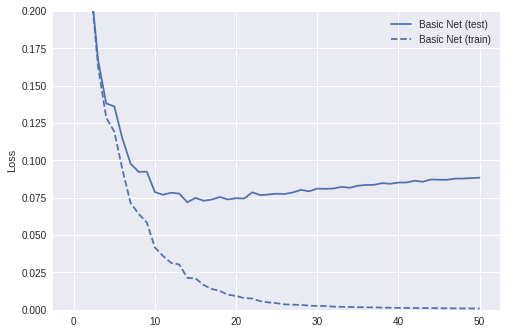

In [21]:
snc = sns.color_palette()

plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)'])
plt.ylabel('Loss');

This suggests a simple approach to dealing with overfitting: Stop the process when the test performance starts declining.  This technique is known as **early stopping**.  In practice you don't want to stop as soon as performance gets worse once.  You will (probably) notice steps where the performance decreased briefly before improving again.  The usual approach is to save the current state, using [tf.train.Saver](https://www.tensorflow.org/api_docs/python/tf/train/Saver) perhaps, every time it beats the previous best model.  If we manage to go a certain number of steps without beating the best model, we'll stop and restore the state from that model.

Early stopping ensures that we get the best model we noticed and keeps us from doing counterproductive training.  Other techniques we will dicuss can yield better absolute performance, but they too can benefit from early stopping.

## Regularization

Overfitting is caused by the model having too much flexibility, and the main source of flexibility in a neural network is the weights in the neurons.  Specifically, non-zero weights indicate some relationship between the input and the output.  **Regularization** penalizes this flexibility by penalizing non-zero weights.  Thus, the network will only have a weight be non-zero if the benefit to the loss function is greater than the penalty applied for the weight.

There are two main types of regularization: $L_2$-regularization adds a penalty proportional to the sum of the squares of the weights, while $L_1$-regularization uses the sum of the absolute values of the weights.  (The biases are generally not regularized.)

$$ L_2\text{ term: }\alpha\sum W^2 \qquad L_1\text{ term: }\alpha\sum\left|W\right| $$

The hyperparameter $\alpha$ is the regularization parameter.  Its size needs to be set to provide the right amount of flexibility that the net avoids both overfitting and its converse, underfitting.  In general, you will need to do a bit of a search to find the appropriate value for your problem.

> **Aside:** Regularization actually has a Bayesian motivation.  In our simple example with the polynomial fit, we realized that we had a prior: we thought a linear model with noise was more probable than a $19^{th}$-degree polynomial model.  Similarly, in the case of neural networks we expect weight of zero are more probable than non-zero weights.  The regularization terms add in the Bayesian prior that we expect the weights to come from a certain distribution centered about zero.

If you were building the neural net by hand, adding in the regularization term would be easy.  If `W` is you weight matrix, you can add to your loss term something like
```python
alpha * tf.reduce_sum(tf.square(W))
```
With the layer API, we need to do a little bit more work, since we don't get the weight variables directly.  The `tf.layers.dense` function takes a `kernel_regularizer` argument.  A regularizer can be passed in, and a new tensor containing the regularization loss for that layer is created.

In the code below, we set up a neural network in the same way we did before, with the addition of a `tf.contrib.l2_regularizer` on each level.  This takes the parameter $\alpha$ as an argument.  We found this value of alpha to work after some trial and error.

In [22]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")
alpha = 0.0001

hidden1 = tf.layers.dense(x, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

hidden2 = tf.layers.dense(hidden1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

y = tf.layers.dense(hidden2, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

We don't get Python references to those tensors directly.  They are all tagged as regularization losses, though, so we can easily assemble a collection of all of the tensors.

In [23]:
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_loss

[<tf.Tensor 'dense/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]

Then we choose to minimize the sum of the cross entropy and all of those regularization terms.

In [24]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss + tf.add_n(reg_loss))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

res_reg = train_mnist(x, y_label, loss, accuracy, train, training, n_steps, 1000)

Test:  2.80375, 0.08920
Train: 2.78901, 0.09067
Test:  0.30989, 0.90850
Train: 0.31686, 0.90698
Test:  0.22414, 0.93440
Train: 0.22814, 0.93413
Test:  0.18232, 0.94380
Train: 0.18081, 0.94491
Test:  0.14391, 0.95640
Train: 0.13865, 0.95916
Test:  0.12588, 0.96120
Train: 0.11610, 0.96589
Test:  0.11770, 0.96440
Train: 0.10533, 0.96927
Test:  0.10758, 0.96780
Train: 0.08846, 0.97447
Test:  0.09717, 0.97030
Train: 0.07555, 0.97827
Test:  0.09504, 0.97210
Train: 0.07317, 0.97816
Test:  0.08531, 0.97360
Train: 0.06065, 0.98316
Test:  0.08478, 0.97230
Train: 0.05766, 0.98389
Test:  0.08081, 0.97570
Train: 0.05118, 0.98631
Test:  0.07712, 0.97630
Train: 0.04698, 0.98798
Test:  0.07469, 0.97680
Train: 0.04366, 0.98900
Test:  0.09088, 0.97070
Train: 0.05931, 0.98175
Test:  0.07422, 0.97570
Train: 0.04107, 0.98971
Test:  0.07096, 0.97680
Train: 0.03851, 0.99040
Test:  0.07212, 0.97610
Train: 0.03571, 0.99164
Test:  0.06812, 0.97780
Train: 0.03245, 0.99318
Test:  0.07030, 0.97680
Train: 0.03178, 

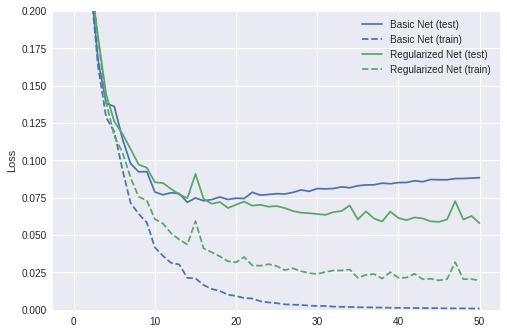

In [25]:
plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.plot(res_reg['test_loss'], color=snc[1])
plt.plot(res_reg['train_loss'], color=snc[1], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)',
            'Regularized Net (test)', 'Regularized Net (train)'])
plt.ylabel('Loss');

Note that the gap between training and test performance is smaller, indicating the overfitting has been significantly diminished.  This is effected by both an improvement in the test performance and a decrease in the training performance.  The test performance plateaus, but does not seem to start growing.

## Dropout

Regularization is a popular mechanism for simple linear models, where training is rather fast.  This makes it easy to try a number of values for $\alpha$ in order to determine the optimal value.  Deep nets take much longer to train, making this search much more painful.

For this reason, another approach for dealing with overfitting has been widely adopted.  Introduced Hinton, Srivastava, *et al*, in two [recent](https://arxiv.org/pdf/1207.0580.pdf) [papers](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf), **dropout** is a remarkably simple strategy.  At each training step, a random selection of neurons are removed from the network:

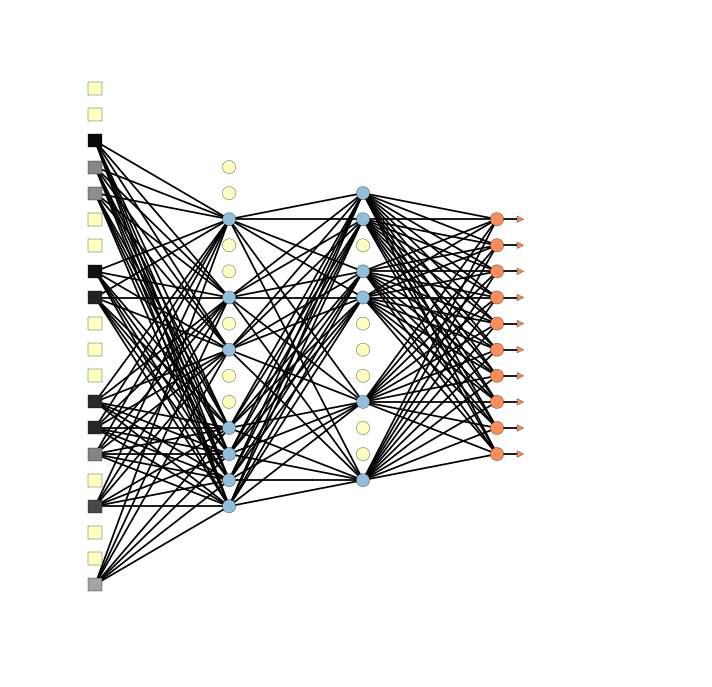

In [26]:
# Network with 50% dropput
draw_neural_net_fig([20, 14, 12, 10], 0.5)

The idea behind this is to keep individual neurons from becoming too specialized.  Because each neuron may or may not be in any given run, , it cannot be the only neuron detecting a particular feature.  If that feature is important, responsibility for its detection needs to be spread out among several neurons.  When we make a prediction, we will keep all of the neurons, in order to make the best prediction possible.

Another way of thinking about dropout is that, instead of training a single network of $N$ neurons, we are training $2^N$ networks of different combinations of neurons.  Then when we make a prediction, we are essentially taking an ensemble average of all of these $2^N$ networks.  A well-known feature of ensemble models is that they tend to avoid overfitting.

Dropout is provided by the `tf.layers.dropout` function.  In addition to setting some fraction $p$ of the components of the input tensor to zero, it scales the remaining components by $1/(1-p)$.  This ensures that that average input to each layer will be the same during training and testing.  This function takes a flag to indicate whether dropout should occur; this is the purpose of the `training` placeholder we've been using.

In the code below, we create a dropout variable.  This will be set to some fraction $p$ during training and to $0$ during testing.

In [27]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")
dropout = 0.2

drop1 = tf.layers.dropout(x, dropout, training=training)
hidden1 = tf.layers.dense(drop1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5))

drop2 = tf.layers.dropout(hidden1, dropout, training=training)
hidden2 = tf.layers.dense(drop2, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

drop3 = tf.layers.dropout(hidden2, dropout, training=training)
y = tf.layers.dense(drop3, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

The standard value for dropout is 50%, which works well for most problems.  In this example, we'll use only a 20% dropout.  It trains a bit faster, but it doesn't do quite as good of a job of dealing with overfitting.

In [28]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

res_drop = train_mnist(x, y_label, loss, accuracy, train, training, n_steps, 1000)

Test:  3.12833, 0.11350
Train: 3.13478, 0.11235
Test:  0.30019, 0.91190
Train: 0.31669, 0.90685
Test:  0.21816, 0.93460
Train: 0.22832, 0.93184
Test:  0.17617, 0.94750
Train: 0.17902, 0.94573
Test:  0.14762, 0.95380
Train: 0.14714, 0.95533
Test:  0.13313, 0.95760
Train: 0.13034, 0.96000
Test:  0.11919, 0.96180
Train: 0.11339, 0.96484
Test:  0.10886, 0.96500
Train: 0.09874, 0.96940
Test:  0.10061, 0.96850
Train: 0.09004, 0.97205
Test:  0.09621, 0.96900
Train: 0.08306, 0.97400
Test:  0.08878, 0.97160
Train: 0.07556, 0.97631
Test:  0.08350, 0.97260
Train: 0.06892, 0.97860
Test:  0.07976, 0.97470
Train: 0.06381, 0.98056
Test:  0.07777, 0.97460
Train: 0.05974, 0.98142
Test:  0.07401, 0.97590
Train: 0.05461, 0.98333
Test:  0.07091, 0.97770
Train: 0.05145, 0.98407
Test:  0.06994, 0.97750
Train: 0.04883, 0.98491
Test:  0.06839, 0.97750
Train: 0.04740, 0.98522
Test:  0.06734, 0.97870
Train: 0.04435, 0.98638
Test:  0.06337, 0.97930
Train: 0.04105, 0.98747
Test:  0.06255, 0.98000
Train: 0.03847, 

KeyboardInterrupt: 

In [ ]:
plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.plot(res_reg['test_loss'], color=snc[1])
plt.plot(res_reg['train_loss'], color=snc[1], ls='--')
plt.plot(res_drop['test_loss'], color=snc[2])
plt.plot(res_drop['train_loss'], color=snc[2], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)',
            'Regularized Net (test)', 'Regularized Net (train)',
            'Dropout Net (test)', 'Dropout Net (train)'])
plt.ylabel('Loss');

## Batch Normalization

Another [recently-developed](https://arxiv.org/pdf/1502.03167v3.pdf) tool for deep networks is **batch normalization**.  Although it can help with overfitting, it was originally developed to deal with the vanishing gradient problem.  Recall that activation functions have flat regions, where their gradients are small.  When the input is in these regions, gradient descent will only move the weights small amounts, leaving them stuck in the low-gradient regions.  Intelligent choices for initializations and activation functions try to avoid this as much as possible.

Batch normalization takes a more proactive approach, scaling and shifting the inputs so that the average input, over the whole batch, has a target mean and standard deviation.  These target values become parameters of the model, tuned during training.

By keeping gradients from vanishing, batch normalization reduces the importance of the weight initialization and the activation function.  Larger learning rates can be used.  Although the initial steps may proceed more slowly, as the correct normalizations must be learned, learning should proceed much faster overall than without.  Batch normalization can also have a regularization effect, reducing the propensity towards overfitting!

The `tf.layers.batch_normalization` function takes care of all of this work for us.  Because normalization should be applied directly before the activation, we can no longer use the activation option built into `tf.layers.dense`.  Instead, we apply the activation function by hand.  This implementation uses an exponentially-weighted moving average to calculate the batch means and standard deviations.  This is governed by the momentum parameter, which specifies the weight of the previous estimate.  It should usually be close to 1, even more so for large datasets and small batches.

In [ ]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")
m = 0.99

hidden1 = tf.layers.dense(x, hidden_size, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5))
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=m)
act1 = tf.nn.sigmoid(bn1)

hidden2 = tf.layers.dense(act1, hidden_size, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=m)
act2 = tf.nn.sigmoid(bn2)

y = tf.layers.dense(act2, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

We have to make sure the operations to do the batch average calculation are run each training step.  These operations are tagged with `tf.GraphKeys.UPDATE_OPS`.  Once we have them, we could run them once per training set.  A more convenient solution is to mark these operations as "control dependencies" of the training operation.  This will ensure than they run before the training step.  The `tf.control_dependencies` context manager handles this for us.

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

res_bn = train_mnist(x, y_label, loss, accuracy, train, training, n_steps, 1000)

In [ ]:
plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.plot(res_reg['test_loss'], color=snc[1])
plt.plot(res_reg['train_loss'], color=snc[1], ls='--')
plt.plot(res_drop['test_loss'], color=snc[2])
plt.plot(res_drop['train_loss'], color=snc[2], ls='--')
plt.plot(res_bn['test_loss'], color=snc[4])
plt.plot(res_bn['train_loss'], color=snc[4], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)',
            'Regularized Net (test)', 'Regularized Net (train)',
            'Dropout Net (test)', 'Dropout Net (train)',
            'Batch Normalization (test)', 'Batch Normalization (train)'])
plt.ylabel('Loss');

We can see that training with batch normalization proceeded more quickly.  It appears the the normalization effect is missing here; the final performance is very similar to the basic net performance.

## Exercise: Implement early stopping

Add early stopping to the optimization routine.  A good way to store a model is to use a [tf.train.Saver](https://www.tensorflow.org/api_docs/python/tf/train/Saver).  Call `.save()` on the Saver object to persist the variable state to a file of your choosing.  Call `.restore()` with that filename to reload that state.

## Exercise: Explore dropout

Change the dropout rate of the model.  (The usual standard is 50%.)  How does it impact the eventual performance of the model? The amount of overfitting?  The time it takes to converge?

## Exercise: Changing the learning rate

Explore other values of the learning rate.  How large can it be before the model becomes unstable?  Does this depend on the complexity of the model?  How is it impacted by batch normalization?

Test:  2.32924, 0.10090
Train: 2.32964, 0.09916
Test:  0.29504, 0.91750
Train: 0.29589, 0.91602
Test:  0.19231, 0.94290
Train: 0.18797, 0.94602
Test:  0.15527, 0.95390
Train: 0.14125, 0.95956
Test:  0.13280, 0.96050
Train: 0.11774, 0.96505
Test:  0.12851, 0.96320
Train: 0.10599, 0.96922
Test:  0.11556, 0.96620
Train: 0.08689, 0.97533
Test:  0.11763, 0.96540
Train: 0.08189, 0.97602
Test:  0.11327, 0.96850
Train: 0.07493, 0.97840
Test:  0.11061, 0.96790
Train: 0.06688, 0.98085
Test:  0.10828, 0.96790
Train: 0.06603, 0.98036
INFO:tensorflow:Restoring parameters from /tmp/mnist_model.ckpt


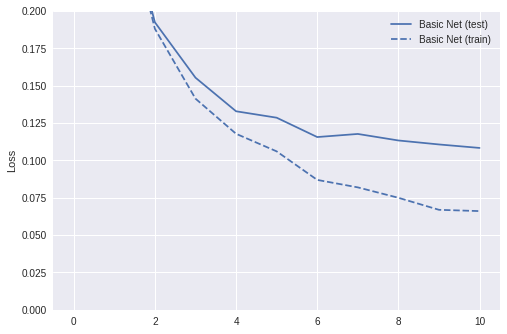

In [40]:
# key - early stopping
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")
hidden_size = 32
alpha = 0.0001

hidden1 = tf.layers.dense(x, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

hidden2 = tf.layers.dense(hidden1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

y = tf.layers.dense(hidden2, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))



def train_mnist(x, y_label, loss, accuracy, train, training, steps_total, steps_print):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    reset_vars()
    saver = tf.train.Saver()
    best_loss = 100
    for i in xrange(steps_total):
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        sess.run(train,
                 feed_dict={x: batch_x, y_label: batch_y, training: True})
        if i % steps_print == 0 or i == steps_total - 1:
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.test.images,
                                       y_label: mnist.test.labels,
                                       training: False})
            metrics['test_loss'].append(l)
            metrics['test_acc'].append(a)
            print "Test:  %0.5f, %0.5f" % (l, a)
            if l < best_loss:
                best_loss = 1
                saver.save(sess, "/tmp/mnist_model.ckpt")
                steps_since_best=0
            else:
                steps_since_best +=1
                if steps_since_best >=5:
                    break
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.train.images, 
                                       y_label: mnist.train.labels,
                                       training: False})
            metrics['train_loss'].append(l)
            metrics['train_acc'].append(a)
            print "Train: %0.5f, %0.5f" % (l, a)
            saver.save(sess, 'my-model', global_step=i)
            
    saver.restore(sess, "/tmp/mnist_model.ckpt")
    return metrics

res = train_mnist(x, y_label, loss, accuracy, train, training, 10000, 1000);

snc = sns.color_palette()
plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)'])
plt.ylabel('Loss');



*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*